<a href="https://colab.research.google.com/github/auroramugnai/arXiv_classification/blob/main/arXiv_classification/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [ ]:
!git clone https://github.com/auroramugnai/arXiv_classification.git
%cd arXiv_classification/arXiv_classification

Cloning into 'arXiv_classification'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 135 (delta 79), reused 13 (delta 5), pack-reused 0
Receiving objects: 100% (135/135), 3.00 MiB | 6.91 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/arXiv_classification/arXiv_classification


# 1) Build the dataset

In [ ]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

from utils import remove

In [ ]:
SEED = 42 # fix random seed for reproducibility

## Download the dataset
The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [ ]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 99% 1.26G/1.28G [00:11<00:00, 208MB/s]
100% 1.28G/1.28G [00:11<00:00, 119MB/s]


Unzip the downloaded file.

In [ ]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    # extract .zip in the same directory
    zip_ref.extractall('./')

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [ ]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## Get rid of some unnecessary information

In [ ]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep articles that have at most 3 categories.
has_categs = lambda x: len(x['categories'].split(' ')) in {1,2,3}

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).filter(has_categs).map(cut_info).compute())

# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
3,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...
4,0707.0570,Gauss--Berezin integral operators and spinors ...,"[math.RT, math-ph, math.MP]",We obtain explicit formulas for the spinor r...


## Get a fixed number of articles
To speed up computation and avoid a session crash.

In [ ]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data
if(len(df) > num_data):
    n_sample = num_data
    random.seed(SEED)
    df = df.sample(n=n_sample, axis=0)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 313216 articles.
The dataset contains 20000 articles.


# Texts processing

In [ ]:
!pip install -U spacy -q
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
import en_core_web_sm
from tqdm import tqdm

In [ ]:
# Apply the remove function.
nlp = spacy.load("en_core_web_sm")
tqdm.pandas()

rem_abs = lambda x: remove(text=x["abstract"], nlp=nlp)
df["abstract_processed"] = df.progress_apply(rem_abs, axis=1)
rem_tit = lambda x: remove(text=x["title"], nlp=nlp)
df["title_processed"] = df.progress_apply(rem_tit, axis=1)

df.tail()

100%|██████████| 20000/20000 [03:16<00:00, 101.71it/s]


,id,title,category,abstract,abstract_processed,title_processed
202617,2310.13425,An overview of optimization approaches for sch...,[math.OC],Public transport is vital for meeting people...,public transport be vital for meet people mobi...,an overview of optimization approach for sched...
47337,2212.08021,Political advertisement on Facebook and Instag...,"[cs.CY, cs.SI]",Targeted advertising on online social platfo...,target advertising on online social platform h...,political advertisement on facebook and instag...
250143,2401.07157,A matrix pencil approach to the Morgan's problem,"[eess.SY, cs.SY]",The problem of decoupling a nonsquare state ...,the problem of decouple a nonsquare state spac...,a matrix pencil approach to the morgan problem
28316,2207.14142,Experimental Simulation of Larger Quantum Circ...,[quant-ph],Although near-term quantum computing devices...,although near term quantum computing device be...,experimental simulation of larger quantum circ...
27431,2207.09132,Anisotropic deformation of the 6-state clock m...,[cond-mat.stat-mech],The two-dimensional $q$-state clock models e...,the two dimensional clock model exhibit the be...,anisotropic deformation of the state clock mod...


In [ ]:
# Add a space to separate title and abstract.
df["title_processed"] = df["title_processed"].astype(str) + " "
df["text"] = df["title_processed"] + df["abstract_processed"]

df.head()

,id,title,category,abstract,abstract_processed,title_processed,TEXT
39584,2210.17303,Validation of Stochastic Optimal Control Model...,[math.OC],Stochastic Optimal Control models represent ...,stochastic optimal control model represent the...,validation of stochastic optimal control model...,validation of stochastic optimal control model...
184981,2309.12026,The Imaging X-ray Polarimetry Explorer (IXPE):...,[astro-ph.HE],This thesis focuses on X-ray polarimetry and...,this thesis focus on x ray polarimetry and its...,the imaging x ray polarimetry explorer ixpe pr...,the imaging x ray polarimetry explorer ixpe pr...
309130,2404.12544,Beyond development: Challenges in deploying ma...,"[cs.LG, cs.CE, stat.ML]",Machine learning (ML)-based solutions are ra...,machine learning solution be rapidly change th...,beyond development challenge in deploy machine...,beyond development challenge in deploy machine...
245207,2401.01856,Scaling dimension of $4\pi$-flux monopole oper...,"[hep-lat, cond-mat.str-el, hep-th]",We numerically address the issue of which mo...,we numerically address the issue of which mono...,scale dimension of monopole operator in four f...,scale dimension of monopole operator in four f...
230214,2312.03463,DBCopilot: Scaling Natural Language Querying t...,"[cs.CL, cs.DB, cs.IR]",Text-to-SQL simplifies database interactions...,text to sql simplifie database interaction by ...,dbcopilot scale natural language querying to m...,dbcopilot scale natural language querying to m...


# Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Convert the texts into a TF-IDF matrix.
text = df["text"].values
vectorizer = TfidfVectorizer(max_features=2 ** 12, stop_words='english') # reduce the number of features to 2^12

X = vectorizer.fit_transform(text)

(20000, 4096)

# Dimensionality reduction with PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Reduce the dimensionality of the dataset to 3.
n_components = 3

pca = PCA(n_components=n_components, random_state=42)
tqdm.pandas()
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(20000, 3)

# Find the optimal number of clusters with K-Means

In [ ]:
!pip install kneed -q

In [ ]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from kneed import KneeLocator

10
20
30
40
50
60
70
80
90


<Figure size 640x480 with 0 Axes>

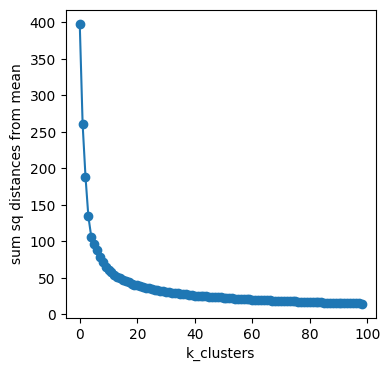

In [ ]:
# Perform the cluster algorithm k_max times and calculate the sum squared distances from mean.
cluster_errors = []

k_max = 100
for i in range(1, k_max):
    if i%10 == 0: print(i)
    n_clusters = i
    pipe_pca_kmean = Pipeline([("cluster", KMeans(n_init='auto',n_clusters=n_clusters, random_state=SEED, verbose=0))]
    )

    pipe_pca_kmean.fit(X_reduced)
    pipe_pca_kmean.predict(X_reduced)
    cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_)

# Plot the sum squared distances from mean.
plt.clf()
plt.figure(figsize=(4,4))
plt.plot(cluster_errors, "o-")
plt.xlabel("k_clusters")
plt.ylabel("sum sq distances from mean")
plt.show()

In [ ]:
# Find the optimal value of k with KneeLocator.
kl = KneeLocator(range(1, k_max), cluster_errors, curve="convex", direction="decreasing")

# Predict the clusters on our dataset

In [ ]:
k_optimal = kl.elbow
print('k_optimal = ', k_optimal)

k_optimal =  10


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Predict the clusters
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
y_pred = kmeans.fit_predict(X_reduced)

# Plot the clustering: UMAP


In [ ]:
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
import time

import seaborn as sns
import plotly.express as px
from umap import UMAP

In [ ]:
start_time = time.time()

# UMAP definition.
umap_embeddings = UMAP(min_dist=0.1, n_components=n_components)
X_umap = umap_embeddings.fit_transform(X_reduced)
print(f"\ncomputation time (s): {time.time()-start_time}")

# Plot.
if n_components == 3: # 3D plot
    x, y, z = list(zip(*X_umap))
    fig = px.scatter_3d(df, x, y, z, color=y_pred.astype(str),
                        color_discrete_sequence=px.colors.qualitative.Dark24,
                        hover_data=['category', 'title'])
    fig.update_traces(marker_size=3)

elif n_components == 2: # 2D plot
    fig = px.scatter(df, x=X_umap[:,0], y=X_umap[:,1], color=y_pred.astype(str),
                     color_discrete_sequence=px.colors.qualitative.Dark24,
                     hover_data=['category', 'title'])
    fig.update_traces(marker_size=3)

fig.show()


computation time (s): 51.466131925582886
